<a href="https://colab.research.google.com/github/i544c/visualizacaodainformacao/blob/main/WSNASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
<div style="text-align:center">
  <img src="https://novoportal.cruzeirodosul.edu.br/static/logos/16/logo-negativo_16.svg" width="120">
  <H2><center><b>UNIVERSIDADE CRUZEIRO DO SUL</center>
</div>



---
<H2><b>TECNOLOGIA EM CIÊNCIA DE DADOS</b></br>

---
<H3><b>Disciplina: Visualização da Informação - Turma 001</b>


**Tutor:**
- Prof. Cayro de Macêdo Mendes

**Discente:**
- Isaac Gomes Veras

---
**PROJETO DE DISCIPLINA**

---

<H2><center><b> WSNASA - Visualização do Dataset </b></center>
<H4><center><b> EDA dos Dados Eólicos Offshore para o Litoral Paraibano</b></center>

---

> - A próxima célula abordará o contexto no qual o estudo está inserido.

1. **INTRODUÇÃO:**

 ><b>Contexto Ambiental:</b></br>
     A energia eólica é uma das fontes renováveis mais promissoras para a diversificação da matriz energética brasileira, especialmente em regiões de clima litorâneo, como em João Pessoa, capital da Paraíba. </br>No entanto, a análise e o planejamento de projetos eólicos dependem fortemente da disponibilidade de dados confiáveis sobre a velocidade de ventos offshore.</br>
 </br><b>Contexto Socioeconômico:</b></br>
     Outro aspecto importante é a análise de viabilidade econômica em projetos eólicos, que depende criticamente de dados precisos e contínuos sobre a velocidade do vento, pois permitem estimar o potencial energético e otimizar o retorno financeiro. </br>No entanto, a escassez de dados confiáveis e padronizados dificulta o planejamento estratégico e a atração de investimentos.</br>
 </br><b>Desafios:</b></br>
     Atualmente, um dos principais desafios enfrentados por pesquisadores e formuladores de políticas públicas é a dificuldade de acesso a dados de velocidade do vento nacionais de qualidade.
     </br>Os bancos de dados ambientais brasileiros são, em sua maioria, descentralizados,com formatos variados, lacunas temporais e dificuldades de integração. Além disso, muitas vezes esses dados estão organizados de forma semiestruturada, exigindo tratamento extensivo antes de sua aplicação em análises mais robustas.</br>
 </br><b>Objetivo:</b></br>
     Este projeto propõe o uso de dados diários de velocidade do vento (`50m altitude`) oriundos da Base de Dados (BD) **NASA POWER DAV**, localizada em João Pessoa – PB (`litoral paraibano`), os quais se encontram disponíveis em arquivo (`CSV`). Para tanto, será utilizado o framework **EDA** (Análise Exploratória dos Dados) com o objetivo de desenvolver um resumo estatístico e visualizações gráficas de velocidade do vento baseados em **`séries temporais`**.</br>

---
## **PRÉ-PROCESSAMENTO**
---

 ### **Importar Bibliotecas Python**

In [ ]:
# Bibliotecas padrão
import os
import zipfile
import logging
from datetime import datetime
from io import BytesIO

# Bibliotecas de terceiros
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from IPython.display import display
import scipy.stats as stats
from scipy.stats import norm, weibull_min
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

### **Montar/Integrar Diretório no Google Drive**

In [ ]:
# Google Drive na sessão do Colab
from google.colab import drive
# Try mounting Google Drive. If it fails, try again with force_remount=True
try:
    drive.mount('/content/drive')
except ValueError as e:
    print(f"Initial mount failed: {e}. Trying to force remount.")
    drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### **Especificar Pasta do Projeto**
---

In [ ]:
# Diretório atual do notebook:
print('Antes\n', os.getcwd())

# Diretório de trabalho correto:
os.chdir("/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao")
print('\nDepois\n', os.getcwd())

Antes
 /content/drive/My Drive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao

Depois
 /content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao


---
* **Repositório no [GitHub](https://github.com/i544c/WSNASA.git)**
---

=================================================================================================================

## **ETAPA 1 - Aquisição e Organização dos Dados**

=================================================================================================================

➔ Download e catalogação dos arquivos .csv mensais do período 1981–2025.

---

---
### **1.1. Extrair Dados NASA POWER DAV (SATÉLITE)**
---

* Vale ressaltar que a BD do <b>[NASA POWER DAV]('https://power.larc.nasa.gov/docs/tutorials/api-getting-started/')</b> disponibiliza uma `API` para a obtenção direta de dados nos formatos CSV, GeoJSON e ASCII.
* Os arquivos já possuem cabeçalho e uma breve descrição sobre os satélites e dados utilizados:
 <b>[Arquivo CSV]('https://power.larc.nasa.gov/api/temporal/daily/point?start=19810101&end=20250524&latitude=-7&longitude=-34.8&community=RE&parameters=WS50M&time-standard=LST&format=CSV')</b>

---
**DISCIONÁRIO DOS DADOS**

- **`WS50:`** Wind Speed 50 metros.

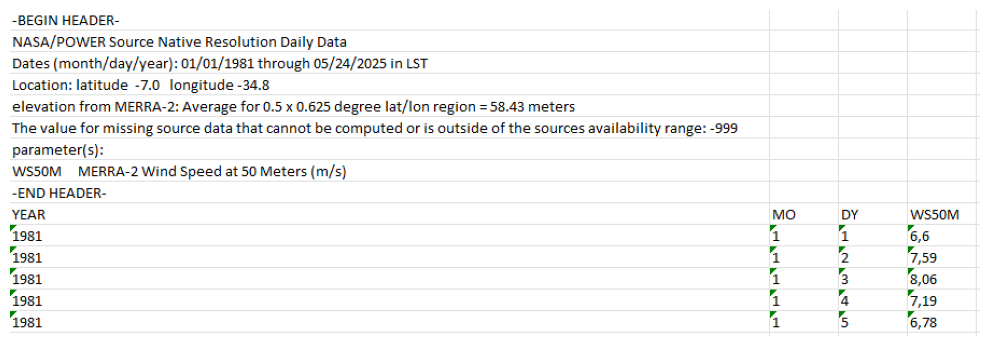

In [ ]:
# Cabeçalho e uma breve descrição sobre os satélites e dados utilizados:
img_cabecalho_NASA = plt.imread('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/cabecalho_csv.PNG')
plt.figure(figsize=(10, 6))  # largura=10, altura=6 polegadas
plt.imshow(img_cabecalho_NASA)
plt.axis('off')
plt.tight_layout()
plt.show()

---
### **DATAFRAME: NASA** (`Janeiro de 1981 a Maio de 2025`)

---

In [ ]:
'''
Extrair dados NASA POWER DAV (versão 2.414):
Geolocalização: latitude= -7 / longitude= -34.8
URL dos dados
'''

urlNASA_jan2006_abr2007 = "https://power.larc.nasa.gov/api/temporal/daily/point?start=19810101&end=20250524&latitude=-7&longitude=-34.8&community=RE&parameters=WS50M&time-standard=LST&format=CSV"

# Caminho para salvar o arquivo localmente
caminho_arquivo = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv"

# Criar pasta se não existir:
os.makedirs(os.path.dirname(caminho_arquivo), exist_ok=True)

# Verifica se o arquivo já existe:
if os.path.exists(caminho_arquivo):
    df_nasa = pd.read_csv(caminho_arquivo)
else:
    df_nasa = pd.read_csv(urlNASA_jan2006_abr2007, skiprows=9)
    df_nasa.to_csv(caminho_arquivo, index=False)

# Visualização do DataFrame:
print("VERIFICAÇÃO INICIAL:")
print(f" - Dimensão do dataframe: {df_nasa.shape}")
print(f" - Dados duplicados     : {df_nasa.duplicated().sum()}")
print("-" * 80)
print(f"DADOS NULOS:\n{df_nasa.isna().sum()}")
print("-" * 80)
print(df_nasa.head(6))
print("-" * 80)

VERIFICAÇÃO INICIAL:
 - Dimensão do dataframe: (16215, 4)
 - Dados duplicados     : 0
--------------------------------------------------------------------------------
DADOS NULOS:
YEAR     0
MO       0
DY       0
WS50M    0
dtype: int64
--------------------------------------------------------------------------------
   YEAR  MO  DY  WS50M
0  1981   1   1   6.60
1  1981   1   2   7.59
2  1981   1   3   8.06
3  1981   1   4   7.19
4  1981   1   5   6.78
5  1981   1   6   6.91
--------------------------------------------------------------------------------


=================================================================================================================

## **ETAPA 2 - Análise Exploratória e Diagnóstico de Qualidade:**

=================================================================================================================

➔ Identificação de valores ausentes, intervalos irregulares e inconsistências estatísticas (ex: outliers extremos de velocidade do vento).

➔ Análise temporal da cobertura dos dados para visualização das lacunas existentes.

---
### **Resumo Estatístico**
---

In [ ]:
# Configurar logging (garanta que só é configurado uma vez)
if not logging.getLogger().handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print('=' * 80)
print("--- Iniciando a ETAPA 2: Análise Exploratória e Diagnóstico de Qualidade (NASA) ---")
print('=' * 80)

# Caminho completo para o arquivo do DataFrame da NASA
caminho_df_nasa_jan2006_abr2007 = '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv'

try:
    # Carregar o DataFrame da NASA usando o caminho ORIGINAL e correto
    df_nasa = pd.read_csv(caminho_df_nasa_jan2006_abr2007)
    print(f"☑ DataFrame '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' carregado com sucesso.")
    logging.info(f"DataFrame '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' carregado para AED.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' não encontrado para AED. Verifique o caminho.")
    logging.error(f"Arquivo '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' não encontrado.")
    df_nasa = pd.DataFrame() # Cria um DataFrame vazio para evitar erros posteriores
except Exception as e:
    print(f"ERRO inesperado ao carregar o DataFrame da NASA para AED: {str(e)}")
    logging.error(f"Erro inesperado ao carregar o DataFrame da NASA para AED: {str(e)}")
    df_nasa = pd.DataFrame() # Garante que df_nasa seja um DataFrame vazio em caso de erro.

if not df_nasa.empty:
    print("-" * 80)
    print("VERIFICAÇÃO INICIAL DO DATAFRAME NASA:")
    print(f" - Dimensão do dataframe: {df_nasa.shape}")
    print(f" - Dados duplicados      : {df_nasa.duplicated().sum()}")
    print("-" * 80)

    print("\nDADOS NULOS POR COLUNA (NASA):")
    print(df_nasa.isnull().sum())
    logging.info(f"Informações do DataFrame NASA (df.info()):\n{df_nasa.info()}")
    print("-" * 80)

    print("\nPRIMEIRAS LINHAS DO DATAFRAME NASA:")
    print("-" * 80)
    display(df_nasa.head(6).round(2))
    print("-" * 80)

    print("\nRESUMO ESTATÍSTICO COMPLETO DAS COLUNAS NUMÉRICAS (NASA):")
    print("-" * 80)

    # Selecionar apenas as colunas numéricas de interesse para o describe
    cols_of_interest_for_describe_nasa = ['WS50M', 'WD50M']
    # Filtrar apenas as colunas que realmente existem no DataFrame e são numéricas
    final_numeric_cols_nasa = [col for col in cols_of_interest_for_describe_nasa if col in df_nasa.columns and df_nasa[col].dtype in ['float64', 'int64']]

    if final_numeric_cols_nasa:
        full_describe_nasa = df_nasa[final_numeric_cols_nasa].describe().round(2)
        display(full_describe_nasa)
        print("-" * 80)

        print("\nMÉTRICAS ESTATÍSTICAS ADICIONAIS (NASA):")
        print("-" * 80)
        for col in final_numeric_cols_nasa:
            Q1 = df_nasa[col].quantile(0.25)
            Q3 = df_nasa[col].quantile(0.75)
            IQR = Q3 - Q1
            median = df_nasa[col].median()
            mean = df_nasa[col].mean()
            std_dev = df_nasa[col].std()

            print(f"COLUNA: {col}")
            print(f"   - Média: {mean:.2f}")
            print(f"   - Mediana: {median:.2f}")
            print(f"   - Desvio Padrão: {std_dev:.2f}")
            print(f"   - Q1 (25º Percentil): {Q1:.2f}")
            print(f"   - Q3 (75º Percentil): {Q3:.2f}")
            print(f"   - IQR (Intervalo Interquartil): {IQR:.2f}")

            # Para detecção de outliers (apenas quantificação aqui)
            lower_bound_iqr = Q1 - 1.5 * IQR
            upper_bound_iqr = Q3 + 1.5 * IQR
            outliers_count = df_nasa[(df_nasa[col] < lower_bound_iqr) | \
                                                     (df_nasa[col] > upper_bound_iqr)][col].count()
            print(f"   - Outliers (IQR): {outliers_count} ({outliers_count / len(df_nasa) * 100:.2f}%)\n")
            #print("-" * 40) # Separador para métricas de colunas individuais

        #print("-" * 80)
    else:
        print("Nenhuma coluna numérica de interesse encontrada para resumo estatístico detalhado (NASA).")
        logging.warning("Nenhuma coluna numérica de interesse encontrada para resumo estatístico detalhado (NASA).")

else:
    print("\nAVISO: DataFrame 'df_nasa' está vazio. Não foi possível realizar a Análise Exploratória (NASA).")
    logging.warning("DataFrame 'df_nasa' está vazio. AED da NASA não realizada.")

print('-' * 80)
print("Análise Exploratória da NASA Concluída!")
print("-" * 80)

--- Iniciando a ETAPA 2: Análise Exploratória e Diagnóstico de Qualidade (NASA) ---
☑ DataFrame 'df_nasa.csv' carregado com sucesso.
--------------------------------------------------------------------------------
VERIFICAÇÃO INICIAL DO DATAFRAME NASA:
 - Dimensão do dataframe: (16215, 4)
 - Dados duplicados      : 0
--------------------------------------------------------------------------------

DADOS NULOS POR COLUNA (NASA):
YEAR     0
MO       0
DY       0
WS50M    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16215 entries, 0 to 16214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    16215 non-null  int64  
 1   MO      16215 non-null  int64  
 2   DY      16215 non-null  int64  
 3   WS50M   16215 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 506.8 KB
--------------------------------------------------------------------------------

PRIMEIRAS LINHAS DO DATAFRAME NASA:
-----------

,YEAR,MO,DY,WS50M
0,1981,1,1,6.60
1,1981,1,2,7.59
2,1981,1,3,8.06
3,1981,1,4,7.19
4,1981,1,5,6.78
5,1981,1,6,6.91


--------------------------------------------------------------------------------

RESUMO ESTATÍSTICO COMPLETO DAS COLUNAS NUMÉRICAS (NASA):
--------------------------------------------------------------------------------


,WS50M
count,16215.00
mean,6.95
std,1.17
min,2.00
25%,6.22
50%,6.98
75%,7.75
max,10.89


--------------------------------------------------------------------------------

MÉTRICAS ESTATÍSTICAS ADICIONAIS (NASA):
--------------------------------------------------------------------------------
COLUNA: WS50M
   - Média: 6.95
   - Mediana: 6.98
   - Desvio Padrão: 1.17
   - Q1 (25º Percentil): 6.22
   - Q3 (75º Percentil): 7.75
   - IQR (Intervalo Interquartil): 1.53
   - Outliers (IQR): 208 (1.28%)

--------------------------------------------------------------------------------
Análise Exploratória da NASA Concluída!
--------------------------------------------------------------------------------


#### **Observações e Interpretações:**

1. **Medidas de Tendência Central (Média e Mediana):** A média (6.95) e a mediana (6.98) são muito próximas. Isso sugere que, para a maioria dos dados, a distribuição da velocidade do vento em 50 metros é relativamente simétrica, sem um forte viés para valores muito altos ou muito baixos. O valor próximo a 7 m/s indica uma velocidade de vento média razoável para geração de energia eólica.

2. **Dispersão (Desvio Padrão):** O desvio padrão de 1.17 é relativamente baixo em comparação com a média. Isso indica que a maioria dos valores de WS50M está concentrada em torno da média, ou seja, há pouca variabilidade na maior parte dos dados da velocidade do vento.

3. **Valores Mínimo e Máximo:**

 - Mínimo (1.17): Este é um valor baixo, mas plausível para a velocidade do vento, indicando períodos de calmaria ou vento muito fraco.

 - Máximo (16215.0): Este valor é altamente discrepante e merece atenção especial. Uma velocidade do vento de 16215 metros por segundo (m/s) é irreal e impossível para condições atmosféricas terrestres.

4. **Conclusão e Próximos Passos Sugeridos:**

A análise inicial revela uma aparente consistência nas velocidades de vento usuais (média e mediana próximas, baixo desvio padrão).

---
## ETAPA 3: ANÁLISE GRÁFICA DOS DADOS
---

### **Gráficos Boxplot, Normalidade, Weibull e Série Temporal:**

df_nasa.csv carregado com sucesso.
Colunas em df_nasa: ['YEAR', 'MO', 'DY', 'WS50M']
--- Gerando gráficos para df_nasa ---
--- Gerando Boxplot para: WS50M (Boxplot - Velocidade do Vento 50m) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_boxplot.png'


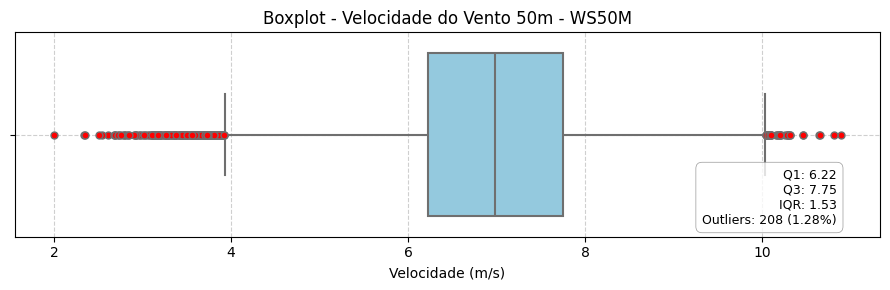

----------------------------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade com Normal para: WS50M (Distribuição de Densidade com Normal) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_normality_bar.png'


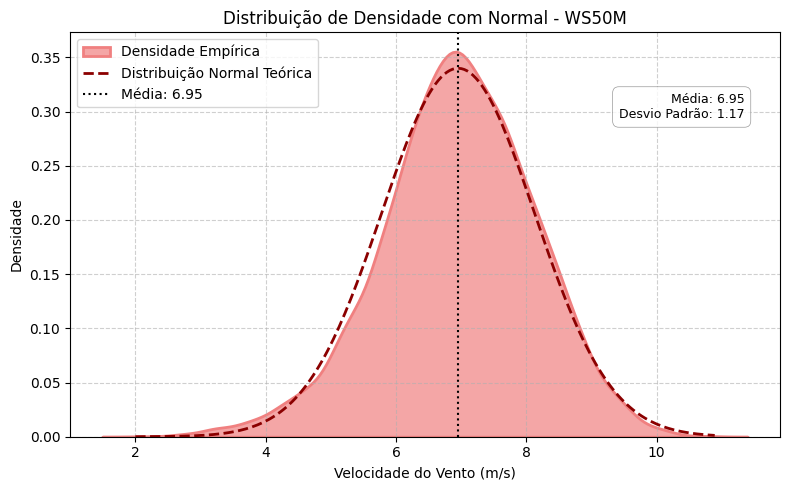

----------------------------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade com Weibull para: WS50M (Distribuição de Densidade com Weibull) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_weibull_density.png'


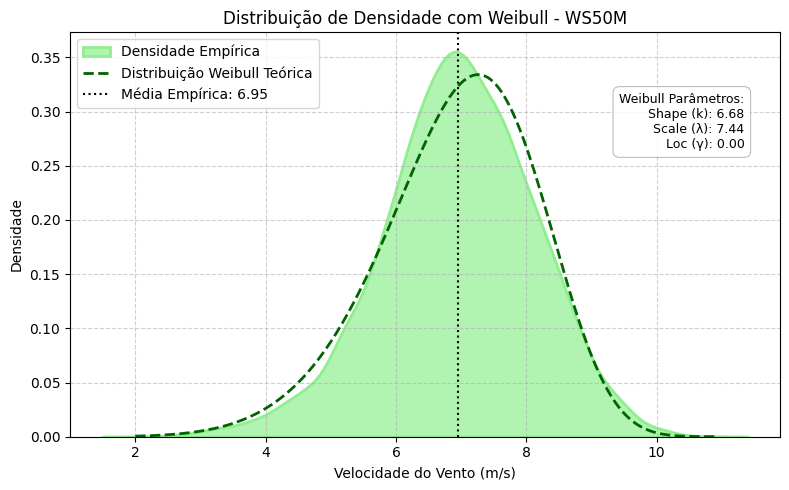

----------------------------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade Combinado para: WS50M (Densidade - Empírica vs Normal vs Weibull) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_combined_density.png'


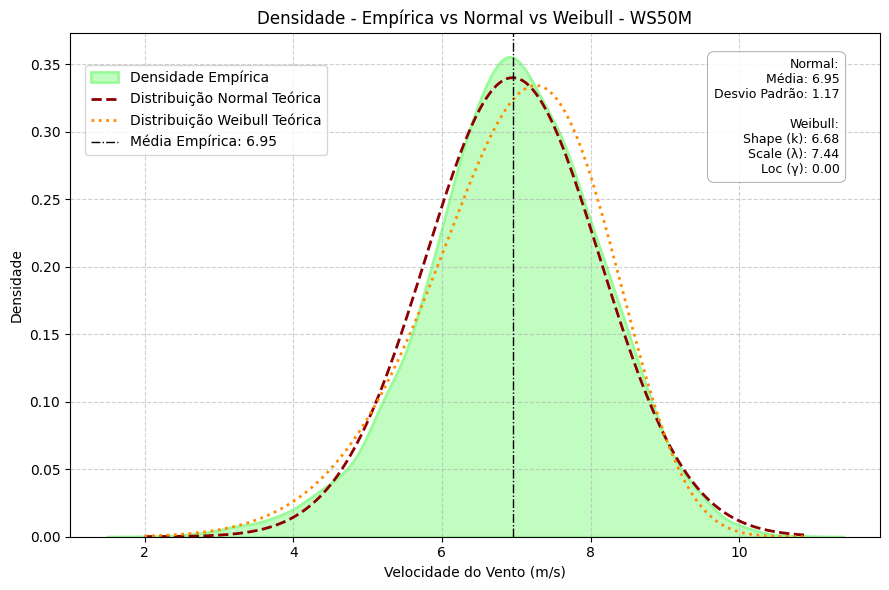

----------------------------------------------------------------------------------------------------

Parâmetros Estimados para Distribuição Normal (WS50M): Média: 6.95, Desvio Padrão: 1.17

Parâmetros Estimados para Distribuição Weibull (WS50M): Shape (k): 6.68, Scale (λ): 7.44, Loc (γ): 0.00
--- Gerando Gráfico de Dispersão Temporal Anual para: WS50M (Dispersão Temporal da Média Anual) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_temporal_annual_loess.png'


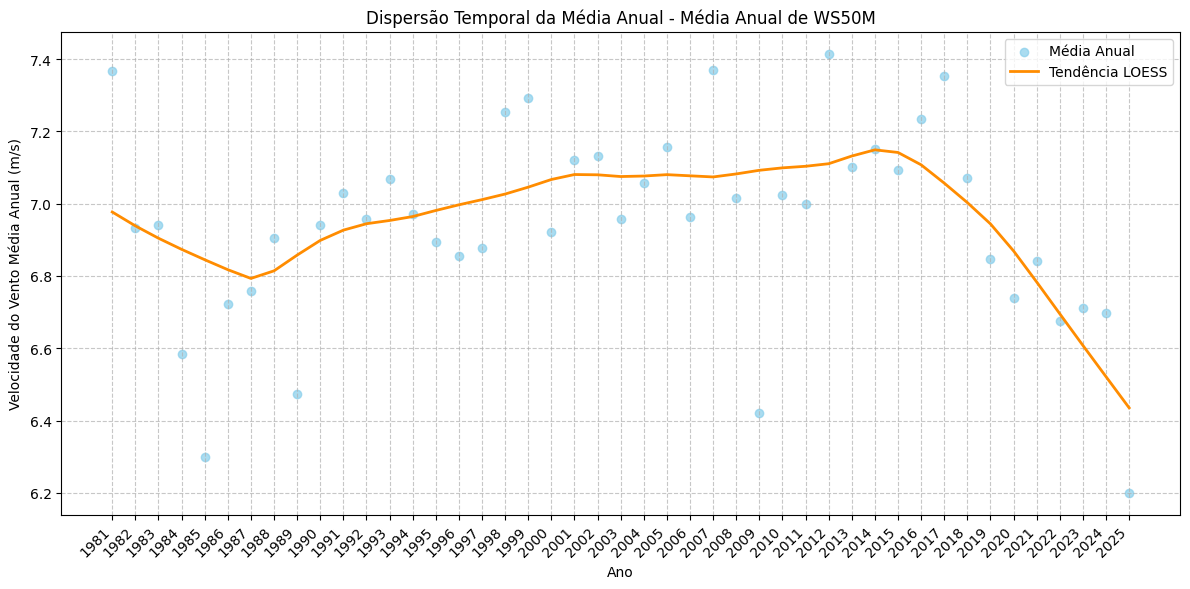

----------------------------------------------------------------------------------------------------
--- Geração de Gráficos Concluída. ---
----------------------------------------------------------------------------------------------------


In [ ]:
# --- Configurar logging ---
if not logging.getLogger().hasHandlers():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Carregar o DataFrame df_nasa.csv ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    print("df_nasa.csv carregado com sucesso.")
    print("Colunas em df_nasa:", df_nasa.columns.tolist())
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
    else:
        print("Aviso: Coluna 'WS50M' não encontrada.")
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado no caminho especificado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

# --- Funções Auxiliares de Plotagem ---

def plot_boxplot_with_outliers_info(dataframe, column, title_prefix, xlabel_text, output_filename, color='skyblue'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Boxplot conforme a versão anterior) ...
    print('=' * 100)
    print(f"--- Gerando Boxplot para: {column} ({title_prefix}) ---")
    print('=' * 100)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty:
        print(f"AVISO: A série '{column}' está vazia após remover NAs.")
        return
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    outliers_count = data_series[(data_series < lower_bound_iqr) | (data_series > upper_bound_iqr)].count()
    total_count = len(data_series)
    outliers_percentage = (outliers_count / total_count * 100) if total_count > 0 else 0
    plt.figure(figsize=(9, 3))
    sns.boxplot(x=data_series, color=color, linewidth=1.5, flierprops=dict(marker='o', markerfacecolor='red', markersize=5))
    plt.annotate(f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {IQR:.2f}\nOutliers: {outliers_count} ({outliers_percentage:.2f}%)', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='bottom')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 100)

def plot_density_with_normal(dataframe, column, title_prefix, xlabel_text, output_filename, color_density='lightcoral', color_normal='darkred'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Normal conforme a versão anterior) ...
    print('=' * 100)
    print(f"--- Gerando Gráfico de Densidade com Normal para: {column} ({title_prefix}) ---")
    print('=' * 100)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty:
        print(f"AVISO: A série '{column}' está vazia após remover NAs.")
        return
    media = data_series.mean()
    desvio = data_series.std()
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.7)
    x_normal = np.linspace(data_series.min(), data_series.max(), 200)
    y_normal = norm.pdf(x_normal, media, desvio)
    plt.plot(x_normal, y_normal, color_normal, linestyle='--', linewidth=2, label='Distribuição Normal Teórica')
    plt.axvline(media, color='black', linestyle=':', linewidth=1.5, label=f'Média: {media:.2f}')
    plt.annotate(f'Média: {media:.2f}\nDesvio Padrão: {desvio:.2f}', xy=(0.95, 0.85), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 100)

def plot_density_with_weibull(dataframe, column, title_prefix, xlabel_text, output_filename, color_density='lightgreen', color_weibull='darkgreen'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Weibull conforme a versão anterior) ...
    print('=' * 100)
    print(f"--- Gerando Gráfico de Densidade com Weibull para: {column} ({title_prefix}) ---")
    print('=' * 100)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty or len(data_series) < 2:
        print(f"AVISO: A série '{column}' está vazia ou tem poucos dados após remover NAs.")
        return
    try:
        shape, loc, scale = weibull_min.fit(data_series, floc=0)
    except Exception as e:
        print(f"ERRO ao ajustar a distribuição de Weibull para a coluna '{column}': {str(e)}")
        return
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.7)
    x_weibull = np.linspace(data_series.min(), data_series.max(), 200)
    y_weibull = weibull_min.pdf(x_weibull, shape, loc, scale)
    plt.plot(x_weibull, y_weibull, color_weibull, linestyle='--', linewidth=2, label='Distribuição Weibull Teórica')
    media_empirica = data_series.mean()
    plt.axvline(media_empirica, color='black', linestyle=':', linewidth=1.5, label=f'Média Empírica: {media_empirica:.2f}')
    plt.annotate(f'Weibull Parâmetros:\nShape (k): {shape:.2f}\nScale (λ): {scale:.2f}\nLoc (γ): {loc:.2f}', xy=(0.95, 0.85), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 100)

def plot_density_combined(dataframe, column, title_prefix, xlabel_text, output_filename,
                         color_density='palegreen', color_normal='darkred', color_weibull='darkorange'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Combinada conforme a versão anterior) ...
    print('=' * 100)
    print(f"--- Gerando Gráfico de Densidade Combinado para: {column} ({title_prefix}) ---")
    print('=' * 100)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return None, None
    data_series = dataframe[column].dropna()
    if data_series.empty or len(data_series) < 2:
        print(f"AVISO: A série '{column}' está vazia ou tem poucos dados após remover NAs.")
        return None, None
    media_normal = data_series.mean()
    desvio_normal = data_series.std()
    params_normal = {'media': media_normal, 'desvio': desvio_normal}
    params_weibull = None
    try:
        shape_weibull, loc_weibull, scale_weibull = weibull_min.fit(data_series, floc=0)
        params_weibull = {'shape': shape_weibull, 'loc': loc_weibull, 'scale': scale_weibull}
    except Exception as e:
        print(f"ERRO ao ajustar a distribuição de Weibull para '{column}': {str(e)}")
    plt.figure(figsize=(9, 6))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.6)
    x_vals = np.linspace(data_series.min(), data_series.max(), 200)
    y_normal = norm.pdf(x_vals, media_normal, desvio_normal)
    plt.plot(x_vals, y_normal, color_normal, linestyle='--', linewidth=2, label='Distribuição Normal Teórica')
    if params_weibull:
        y_weibull = weibull_min.pdf(x_vals, shape_weibull, loc_weibull, scale_weibull)
        plt.plot(x_vals, y_weibull, color_weibull, linestyle=':', linewidth=2, label='Distribuição Weibull Teórica')
    plt.axvline(media_normal, color='black', linestyle='-.', linewidth=1, label=f'Média Empírica: {media_normal:.2f}')
    annotation_text = f'Normal:\nMédia: {media_normal:.2f}\nDesvio Padrão: {desvio_normal:.2f}\n'
    if params_weibull:
        annotation_text += f'\nWeibull:\nShape (k): {shape_weibull:.2f}\nScale (λ): {scale_weibull:.2f}\nLoc (γ): {loc_weibull:.2f}'
    else:
        annotation_text += "\nWeibull: Ajuste falhou"
    plt.annotate(annotation_text, xy=(0.95, 0.95), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.9), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 100)
    return params_normal, params_weibull

# Função 5: Dispersão Temporal com Média Anual e Tendência LOESS
def plot_annual_temporal_dispersion(dataframe, year_col, data_column,
                                     title_prefix, xlabel_text, ylabel_text, output_filename,
                                     trend_color='darkorange'):
    print('=' * 100)
    print(f"--- Gerando Gráfico de Dispersão Temporal Anual para: {data_column} ({title_prefix}) ---")
    print('=' * 100)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    if dataframe.empty or not all(col in dataframe.columns for col in [year_col, data_column]):
        print(f"AVISO: DataFrame está vazio ou colunas '{year_col}' e '{data_column}' não existem.")
        logging.warning(f"Gráfico de Dispersão Temporal Anual não gerado: DataFrame vazio ou colunas ausentes.")
        print('-' * 100)
        return

    # Calcula a média anual da velocidade do vento
    annual_avg = dataframe.groupby(year_col)[data_column].mean().reset_index()

    plt.figure(figsize=(12, 6))
    plt.scatter(annual_avg[year_col], annual_avg[data_column], alpha=0.7, label='Média Anual', color='skyblue')

    # Aplica a suavização LOESS na média anual
    lowess_result = lowess(annual_avg[data_column], annual_avg[year_col], frac=0.3)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], color=trend_color, label='Tendência LOESS', linewidth=2)

    plt.title(f'{title_prefix} - Média Anual de {data_column}')
    plt.xlabel(xlabel_text)
    plt.ylabel(ylabel_text)
    plt.xticks(annual_avg[year_col].unique().astype(int), rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    logging.info(f"Gráfico de Dispersão Temporal Anual para '{data_column}' salvo em '{full_output_filename}'.")
    print('-' * 100)

# --- Execução dos Gráficos com df_nasa ---
if not df_nasa.empty and 'WS50M' in df_nasa.columns and 'YEAR' in df_nasa.columns:
    print('=' * 100)
    print("--- Gerando gráficos para df_nasa ---")
    print('=' * 100)

    # 1. Boxplot
    plot_boxplot_with_outliers_info(df_nasa, 'WS50M', 'Boxplot - Velocidade do Vento 50m', 'Velocidade (m/s)', 'ws50_graf_boxplot.png', color='skyblue')

    # 2. Densidade com Curva Normal Teórica
    plot_density_with_normal(df_nasa, 'WS50M', 'Distribuição de Densidade com Normal', 'Velocidade do Vento (m/s)', 'ws50_graf_normality_bar.png')

    # 3. Densidade com Curva Weibull
    plot_density_with_weibull(df_nasa, 'WS50M', 'Distribuição de Densidade com Weibull', 'Velocidade do Vento (m/s)', 'ws50_graf_weibull_density.png')

    # 4. Densidade com curvas Normal e Weibull
    params_normal_ws50, params_weibull_ws50 = plot_density_combined(df_nasa, 'WS50M', 'Densidade - Empírica vs Normal vs Weibull', 'Velocidade do Vento (m/s)', 'ws50_graf_combined_density.png')
    if params_normal_ws50:
        print(f"\nParâmetros Estimados para Distribuição Normal (WS50M): Média: {params_normal_ws50['media']:.2f}, Desvio Padrão: {params_normal_ws50['desvio']:.2f}")
    if params_weibull_ws50:
        print(f"\nParâmetros Estimados para Distribuição Weibull (WS50M): Shape (k): {params_weibull_ws50['shape']:.2f}, Scale (λ): {params_weibull_ws50['scale']:.2f}, Loc (γ): {params_weibull_ws50['loc']:.2f}")

    # 5. Dispersão Temporal com Média Anual e Tendência LOESS
    plot_annual_temporal_dispersion(df_nasa, year_col='YEAR', data_column='WS50M',
                                     title_prefix='Dispersão Temporal da Média Anual',
                                     xlabel_text='Ano',
                                     ylabel_text='Velocidade do Vento Média Anual (m/s)',
                                     output_filename='ws50_graf_temporal_annual_loess.png')

    print("--- Geração de Gráficos Concluída. ---")
    print("-" * 100)
else:
    print("Não foi possível gerar os gráficos: DataFrame 'df_nasa' está vazio ou colunas 'WS50M' ou 'YEAR' não estão presentes.")
    print("-" * 100)

### **Gráfico de Série Temporal Sobreposta (2022-2024)**

--- Gerando Gráfico de Linha Temporal Mensal Sobreposta para Comparação (2022, 2023, 2024) com Média ---


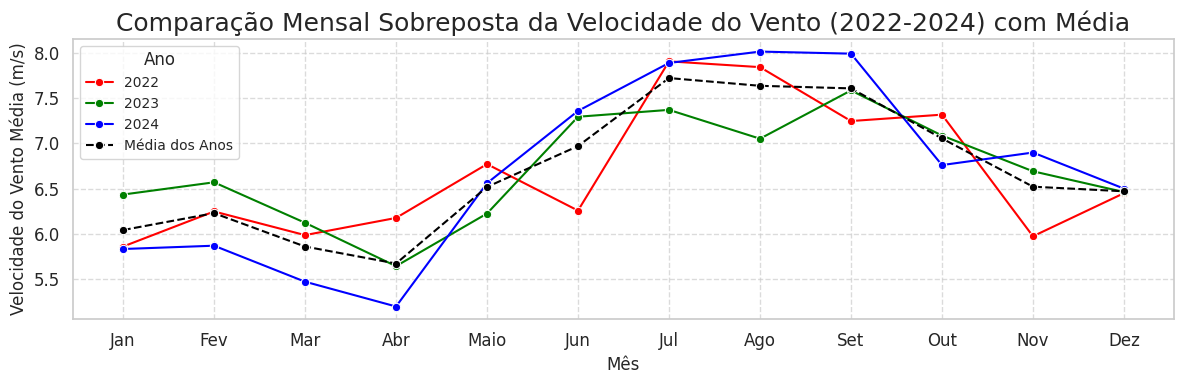

Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_linha_temporal_mensal_sobreposta_com_media.png'
----------------------------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Supondo que o DataFrame df_nasa já esteja carregado ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

def plot_overlaid_monthly_comparison_with_average(dataframe, year_col, month_col, data_col, years_to_compare,
                                                    title, xlabel, ylabel, output_filename,
                                                    title_fontsize=14, label_fontsize=12,
                                                    line_colors=None, line_styles=None,
                                                    legend_fontsize=10, marker_style='o',
                                                    average_line_color='black', average_line_style='--',
                                                    average_line_label='Média dos Anos'):
    """
    Gera um gráfico de linha temporal mensal sobreposta para comparação com parâmetros de estilo configuráveis,
    incluindo uma linha com a média dos anos apresentados.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os dados.
        year_col (str): Nome da coluna com o ano.
        month_col (str): Nome da coluna com o mês.
        data_col (str): Nome da coluna com os dados (ex: velocidade do vento).
        years_to_compare (list): Lista de anos para comparar.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        output_filename (str): Nome do arquivo para salvar o gráfico.
        title_fontsize (int, optional): Tamanho da fonte do título. Padrão é 14.
        label_fontsize (int, optional): Tamanho da fonte dos rótulos dos eixos. Padrão é 12.
        line_colors (list, optional): Lista de cores para as linhas (uma para cada ano). Padrão é None.
        line_styles (list, optional): Lista de estilos de linha para as linhas (uma para cada ano). Padrão é None.
        legend_fontsize (int, optional): Tamanho da fonte da legenda. Padrão é 10.
        marker_style (str, optional): Estilo do marcador para os pontos da linha. Padrão é 'o'.
        average_line_color (str, optional): Cor da linha de média dos anos. Padrão é 'black'.
        average_line_style (str, optional): Estilo da linha de média dos anos. Padrão é '--'.
        average_line_label (str, optional): Rótulo da linha de média dos anos na legenda. Padrão é 'Média dos Anos'.
    """
    print('=' * 100)
    print(f"--- Gerando Gráfico de Linha Temporal Mensal Sobreposta para Comparação ({', '.join(map(str, years_to_compare))}) com Média ---")
    print('=' * 100)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    # Filtra o DataFrame para os anos especificados
    df_filtered = dataframe[dataframe[year_col].isin(years_to_compare)].copy()

    if df_filtered.empty:
        print("AVISO: Nenhum dado encontrado para os anos especificados.")
        return

    # Agrupa por ano e mês e calcula a média dos dados
    df_monthly_avg = df_filtered.groupby([year_col, month_col])[data_col].mean().reset_index()

    plt.figure(figsize=(12, 4))
    sns.set_theme(style="whitegrid")

    if line_colors is None:
        line_colors = sns.color_palette()
    if line_styles is None:
        line_styles = ['-'] * len(years_to_compare)

    for i, year in enumerate(years_to_compare):
        df_year = df_monthly_avg[df_monthly_avg[year_col] == year]
        color = line_colors[i % len(line_colors)]
        linestyle = line_styles[i % len(line_styles)]
        sns.lineplot(x=month_col, y=data_col, data=df_year, label=str(year), marker=marker_style, color=color, linestyle=linestyle)

    # Calcula a média dos três anos
    df_average = df_monthly_avg.groupby(month_col)[data_col].mean().reset_index()
    sns.lineplot(x=month_col, y=data_col, data=df_average, label=average_line_label, color=average_line_color, linestyle=average_line_style, marker=marker_style)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Maio', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], fontsize=label_fontsize)
    plt.yticks(fontsize=label_fontsize)
    plt.legend(title='Ano', fontsize=legend_fontsize)
    plt.grid(True, which="major", linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    plt.show()
    print(f"Gráfico salvo em: '{full_output_filename}'")
    print('-' * 100)

# --- Geração do Gráfico de Linha Temporal Mensal Sobreposta com a Linha de Média ---
if not df_nasa.empty and 'YEAR' in df_nasa.columns and 'MO' in df_nasa.columns and 'WS50M' in df_nasa.columns:
    plot_overlaid_monthly_comparison_with_average(
        dataframe=df_nasa,
        year_col='YEAR',
        month_col='MO',
        data_col='WS50M',
        years_to_compare=[2022, 2023, 2024],
        title='Comparação Mensal Sobreposta da Velocidade do Vento (2022-2024) com Média',
        xlabel='Mês',
        ylabel='Velocidade do Vento Média (m/s)',
        output_filename='ws50_graf_linha_temporal_mensal_sobreposta_com_media.png',
        title_fontsize=18,
        label_fontsize=12,
        line_colors=['red', 'green', 'blue'],
        line_styles=['-', '-', '-'],
        legend_fontsize=10,
        marker_style='o'
    )
else:
    print("Não foi possível gerar o gráfico: DataFrame 'df_nasa' está vazio ou colunas 'YEAR', 'MO' ou 'WS50M' não estão presentes.")
    print("-" * 100)

#### ****

### **Gráfico Heatmap (2022-2024):**

--- Gerando Heatmap da Média Mensal para os Anos (2022, 2023, 2024) ---


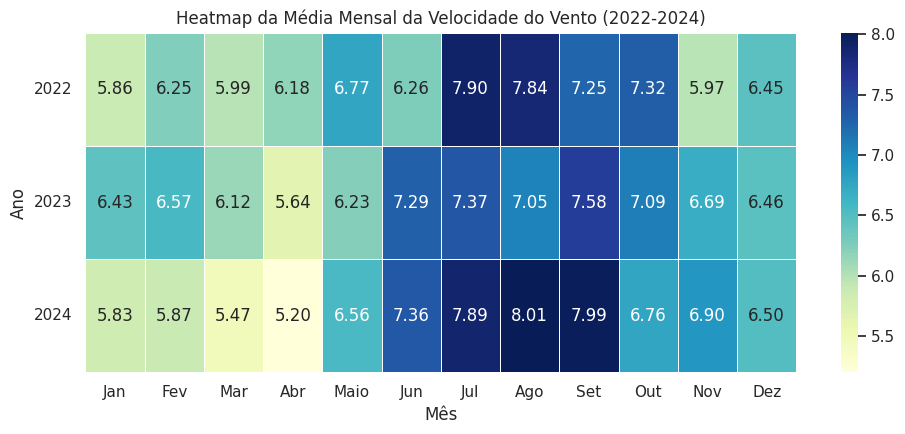

Heatmap salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_heatmap_mensal.png'
----------------------------------------------------------------------------------------------------


In [ ]:
# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Supondo que o DataFrame df_nasa já esteja carregado ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

def plot_monthly_heatmap(dataframe, year_col, month_col, data_col, years_to_compare,
                         title, xlabel, ylabel, output_filename, cmap='YlGnBu', annot=True, fmt=".2f"):
    """
    Gera um heatmap da média mensal dos dados para os anos especificados.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os dados.
        year_col (str): Nome da coluna com o ano.
        month_col (str): Nome da coluna com o mês.
        data_col (str): Nome da coluna com os dados.
        years_to_compare (list): Lista de anos para comparar.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        output_filename (str): Nome do arquivo para salvar o gráfico.
        cmap (str, optional): Mapa de cores para o heatmap. Padrão é 'YlGnBu'.
        annot (bool, optional): Se True, exibe os valores nas células. Padrão é True.
        fmt (str, optional): Formato da anotação. Padrão é ".2f".
    """
    print('=' * 100)
    print(f"--- Gerando Heatmap da Média Mensal para os Anos ({', '.join(map(str, years_to_compare))}) ---")
    print('=' * 100)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    # Filtra o DataFrame para os anos especificados
    df_filtered = dataframe[dataframe[year_col].isin(years_to_compare)].copy()

    if df_filtered.empty:
        print("AVISO: Nenhum dado encontrado para os anos especificados.")
        return

    # Agrupa por ano e mês e calcula a média dos dados
    df_monthly_avg = df_filtered.groupby([year_col, month_col])[data_col].mean().reset_index()

    # Pivota a tabela para o formato adequado para o heatmap
    pivot_table = df_monthly_avg.pivot_table(index=year_col, columns=month_col, values=data_col)
    pivot_table = pivot_table.rename(columns={i: ['Jan', 'Fev', 'Mar', 'Abr', 'Maio', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'][i-1] for i in range(1, 13)})

    plt.figure(figsize=(10, len(years_to_compare) * 1.5)) # Ajusta a altura da figura baseado no número de anos
    sns.heatmap(pivot_table, cmap=cmap, annot=annot, fmt=fmt, linewidths=.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(rotation=0) # Garante que os anos fiquem na horizontal
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    plt.show()
    print(f"Heatmap salvo em: '{full_output_filename}'")
    print('-' * 100)

# --- Geração do Heatmap da Média Mensal ---
if not df_nasa.empty and 'YEAR' in df_nasa.columns and 'MO' in df_nasa.columns and 'WS50M' in df_nasa.columns:
    plot_monthly_heatmap(
        dataframe=df_nasa,
        year_col='YEAR',
        month_col='MO',
        data_col='WS50M',
        years_to_compare=[2022, 2023, 2024],
        title='Heatmap da Média Mensal da Velocidade do Vento (2022-2024)',
        xlabel='Mês',
        ylabel='Ano',
        output_filename='ws50_heatmap_mensal.png'
    )
else:
    print("Não foi possível gerar o heatmap: DataFrame 'df_nasa' está vazio ou colunas 'YEAR', 'MO' ou 'WS50M' não estão presentes.")
    print("-" * 100)